# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 23.1 MB/s 
     |████████████████████████████████| 132 kB 32.5 MB/s 
     |████████████████████████████████| 10.2 MB 58.5 MB/s 
     |████████████████████████████████| 79 kB 2.6 MB/s 
     |████████████████████████████████| 140 kB 62.4 MB/s 
     |████████████████████████████████| 127 kB 39.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 31.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data_by_tokens import gen_pseudo_data_for_token

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Mounted at /content/drive
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


100%|██████████| 213450/213450 [00:00<00:00, 321846.93B/s]


In [ ]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [01:19<00:00, 5100617.47B/s] 


In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [ ]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [ ]:
domain = "emails"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [ ]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 2450
The number of tags 49
The number of samples: 2450
The number of tags 48
after filter tag 2427
after filter tag 2402


In [ ]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Scratch_token_self_learning")

In [ ]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [ ]:
loop_i = 0
token_top_percent = 0.2
cnt_non_ignored_tokens = sum([len(s) for s in domain_dev_word_lst])
token_topn = int(token_top_percent * cnt_non_ignored_tokens)
print("The number of non_ignored_tokens", cnt_non_ignored_tokens)
print("The number of token_topn", token_topn)

The number of non_ignored_tokens 28898
The number of token_topn 5779


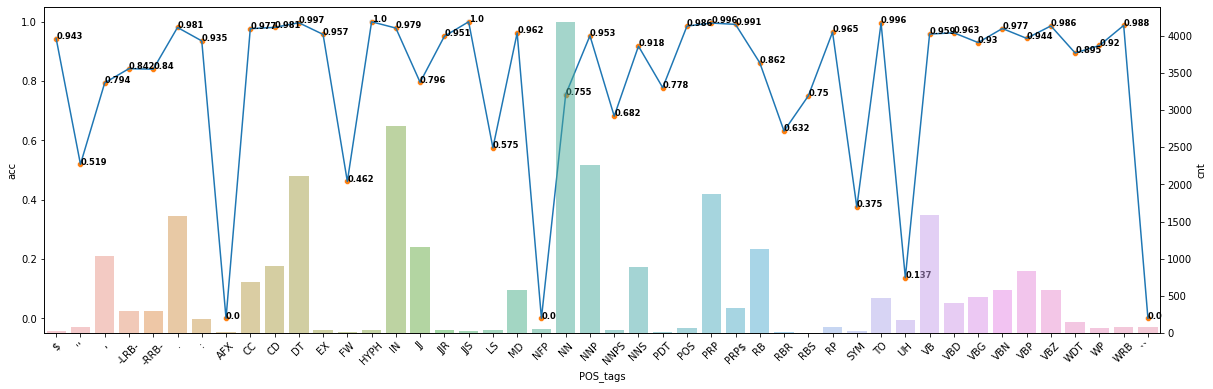

In [ ]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)



Loop 1
domain_dev_word_lst 2427


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 28898
threshold_prob: 0.9998353719711304
Train from scratch...
step: 0, loss: 3.9003281593322754
step: 10, loss: 1.8409364223480225
step: 20, loss: 0.7444138526916504
step: 30, loss: 0.43776845932006836
step: 40, loss: 0.40995416045188904
step: 50, loss: 0.34270012378692627
step: 60, loss: 0.1786322444677353
step: 70, loss: 0.12801621854305267
step: 80, loss: 0.22957617044448853
step: 90, loss: 0.19133472442626953
step: 100, loss: 0.09404276311397552
step: 110, loss: 0.11855751276016235
step: 120, loss: 0.13458088040351868
step: 130, loss: 0.09239047020673752
step: 140, loss: 0.0795406848192215
step: 150, loss: 0.13480646908283234
step: 160, loss: 0.18197602033615112
step: 170, loss: 0.30981406569480896
step: 180, loss: 0.18851333856582642
step: 190, loss: 0.042864859104156494
step: 200, loss: 0.12115475535392761
step: 210, loss: 0.08134430646896362
step: 220, loss: 0.11624450981616974
step: 230, loss: 0.16326579451560974
step: 240, loss: 0.062387309968471

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 23116
threshold_prob: 0.9994452595710754
Train from scratch...
step: 0, loss: 4.0302910804748535
step: 10, loss: 1.9320660829544067
step: 20, loss: 0.827672004699707
step: 30, loss: 0.8554503917694092
step: 40, loss: 0.4551781415939331
step: 50, loss: 0.30792710185050964
step: 60, loss: 0.15376067161560059
step: 70, loss: 0.2210416942834854
step: 80, loss: 0.24916672706604004
step: 90, loss: 0.1622721254825592
step: 100, loss: 0.12166277319192886
step: 110, loss: 0.11379952728748322
step: 120, loss: 0.111454077064991
step: 130, loss: 0.12390084564685822
step: 140, loss: 0.12973688542842865
step: 150, loss: 0.18577763438224792
step: 160, loss: 0.11835398524999619
step: 170, loss: 0.07988612353801727
step: 180, loss: 0.057356350123882294
step: 190, loss: 0.10979193449020386
step: 200, loss: 0.0760662630200386
step: 210, loss: 0.1778607964515686
step: 220, loss: 0.09233659505844116
step: 230, loss: 0.10727768391370773
step: 240, loss: 0.1327732503414154
step:

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 18230
threshold_prob: 0.9988080263137817
Train from scratch...
step: 0, loss: 3.964799165725708
step: 10, loss: 2.230104923248291
step: 20, loss: 0.7385838031768799
step: 30, loss: 0.3609766960144043
step: 40, loss: 0.21957890689373016
step: 50, loss: 0.12253829091787338
step: 60, loss: 0.1651441752910614
step: 70, loss: 0.25731945037841797
step: 80, loss: 0.16074152290821075
step: 90, loss: 0.21180091798305511
step: 100, loss: 0.17619594931602478
step: 110, loss: 0.20514795184135437
step: 120, loss: 0.2055840939283371
step: 130, loss: 0.29237276315689087
step: 140, loss: 0.15855374932289124
step: 150, loss: 0.08282281458377838
step: 160, loss: 0.13867096602916718
step: 170, loss: 0.2309030294418335
step: 180, loss: 0.1688738465309143
step: 190, loss: 0.16927924752235413
step: 200, loss: 0.10274899750947952
step: 210, loss: 0.0730246752500534
step: 220, loss: 0.0890045091509819
step: 230, loss: 0.17575177550315857
step: 240, loss: 0.14987395703792572
step:

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 13234
threshold_prob: 0.9905621409416199
Train from scratch...
step: 0, loss: 3.9086062908172607
step: 10, loss: 1.8655468225479126
step: 20, loss: 0.9022178649902344
step: 30, loss: 0.5354483127593994
step: 40, loss: 0.41371163725852966
step: 50, loss: 0.32342082262039185
step: 60, loss: 0.17704841494560242
step: 70, loss: 0.13645489513874054
step: 80, loss: 0.14942702651023865
step: 90, loss: 0.13412460684776306
step: 100, loss: 0.13160976767539978
step: 110, loss: 0.18696321547031403
step: 120, loss: 0.1683540642261505
step: 130, loss: 0.18177950382232666
step: 140, loss: 0.08939773589372635
step: 150, loss: 0.12599922716617584
step: 160, loss: 0.11283480376005173
step: 170, loss: 0.17018568515777588
step: 180, loss: 0.10190992802381516
step: 190, loss: 0.07832900434732437
step: 200, loss: 0.1462598294019699
step: 210, loss: 0.17556007206439972
step: 220, loss: 0.06957385689020157
step: 230, loss: 0.02638396807014942
step: 240, loss: 0.094131238758564
s

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 8035
threshold_prob: 0.7803137898445129
Train from scratch...
step: 0, loss: 3.8436481952667236
step: 10, loss: 1.7580201625823975
step: 20, loss: 0.7291212677955627
step: 30, loss: 0.3637474477291107
step: 40, loss: 0.4150407910346985
step: 50, loss: 0.34787794947624207
step: 60, loss: 0.2013089656829834
step: 70, loss: 0.28042423725128174
step: 80, loss: 0.18317122757434845
step: 90, loss: 0.18976184725761414
step: 100, loss: 0.14574164152145386
step: 110, loss: 0.2294999212026596
step: 120, loss: 0.12820471823215485
step: 130, loss: 0.06835801899433136
step: 140, loss: 0.14830058813095093
step: 150, loss: 0.13611339032649994
step: 160, loss: 0.07898570597171783
step: 170, loss: 0.20162273943424225
step: 180, loss: 0.050452928990125656
step: 190, loss: 0.10342112183570862
step: 200, loss: 0.05206424370408058
step: 210, loss: 0.19742241501808167
step: 220, loss: 0.1263560652732849
step: 230, loss: 0.05924614146351814
step: 240, loss: 0.03919385373592377
s

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data_by_tokens.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


2427
Total non_ignored tokens 2339
threshold_prob: 0.14202333986759186
Train from scratch...
step: 0, loss: 3.836749792098999
step: 10, loss: 1.7793394327163696
step: 20, loss: 0.7243636846542358
step: 30, loss: 0.5250983834266663
step: 40, loss: 0.24552759528160095
step: 50, loss: 0.2762443721294403
step: 60, loss: 0.1756962388753891
step: 70, loss: 0.20927534997463226
step: 80, loss: 0.18866613507270813
step: 90, loss: 0.17727242410182953
step: 100, loss: 0.11143704503774643
step: 110, loss: 0.16588212549686432
step: 120, loss: 0.12371785193681717
step: 130, loss: 0.1449088603258133
step: 140, loss: 0.2542317509651184
step: 150, loss: 0.12997691333293915
step: 160, loss: 0.10396234691143036
step: 170, loss: 0.19891299307346344
step: 180, loss: 0.15316905081272125
step: 190, loss: 0.07603400945663452
step: 200, loss: 0.04580732807517052
step: 210, loss: 0.07424195110797882
step: 220, loss: 0.11211881786584854
step: 230, loss: 0.1620483547449112
step: 240, loss: 0.05786746367812157
ste

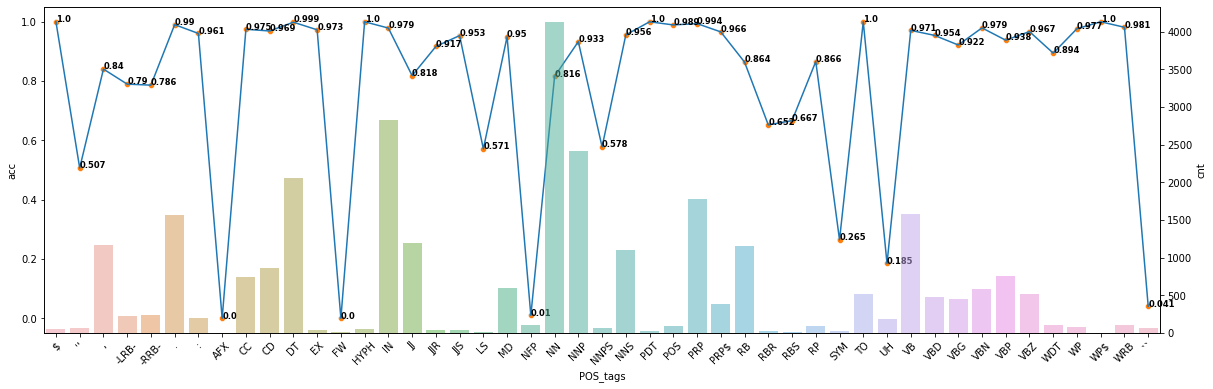

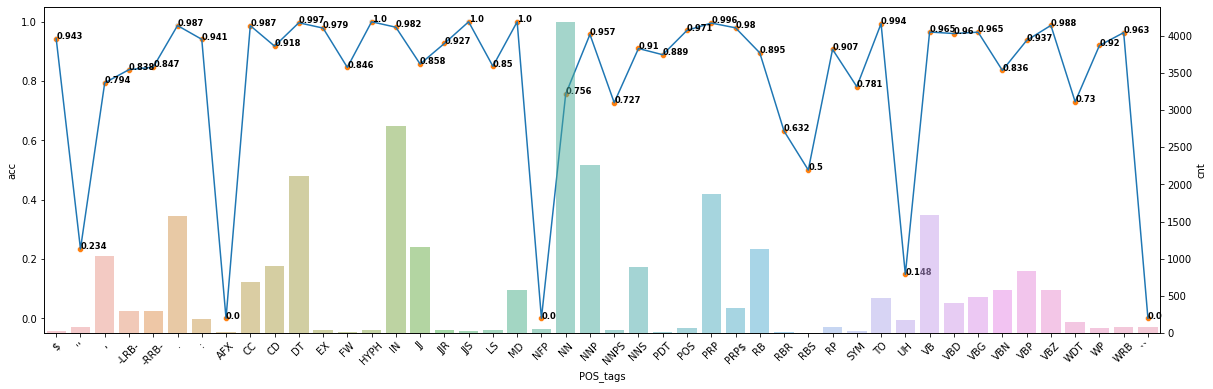

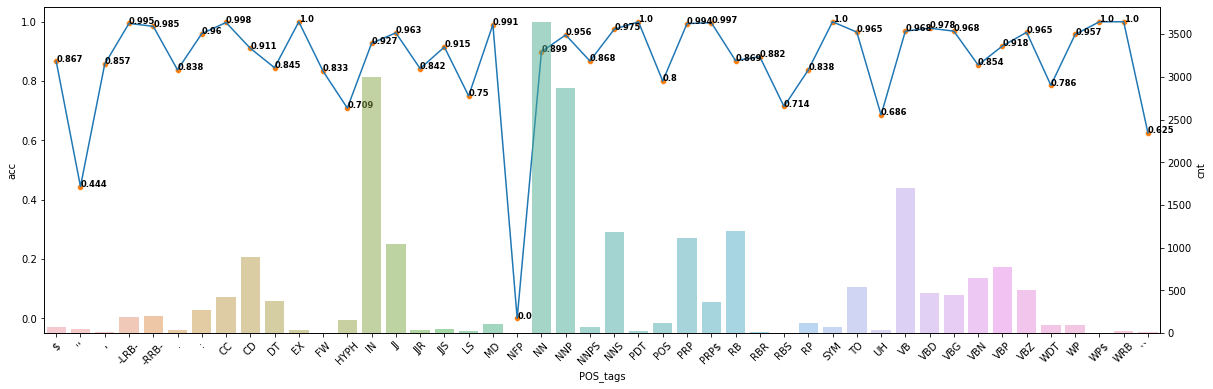

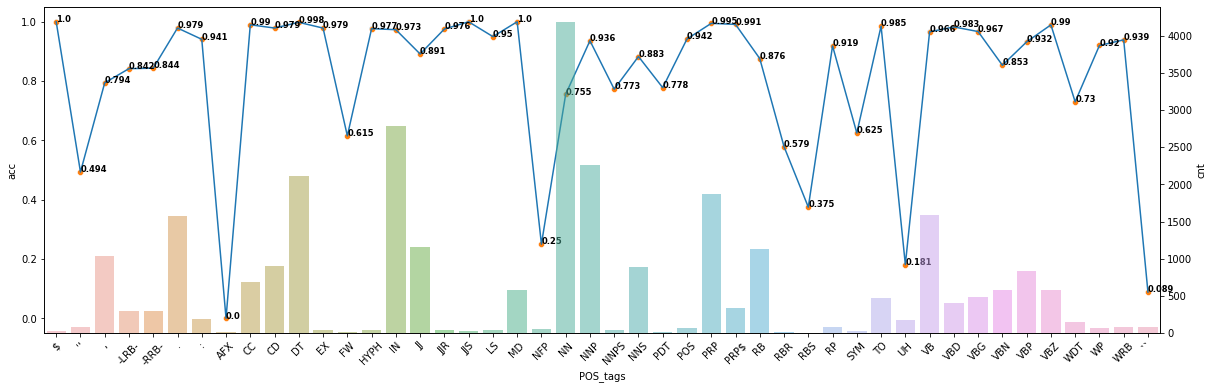

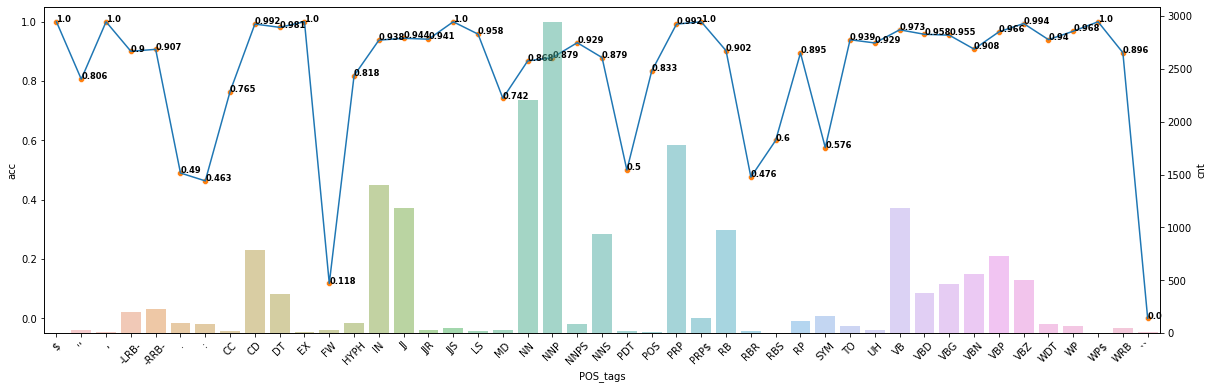

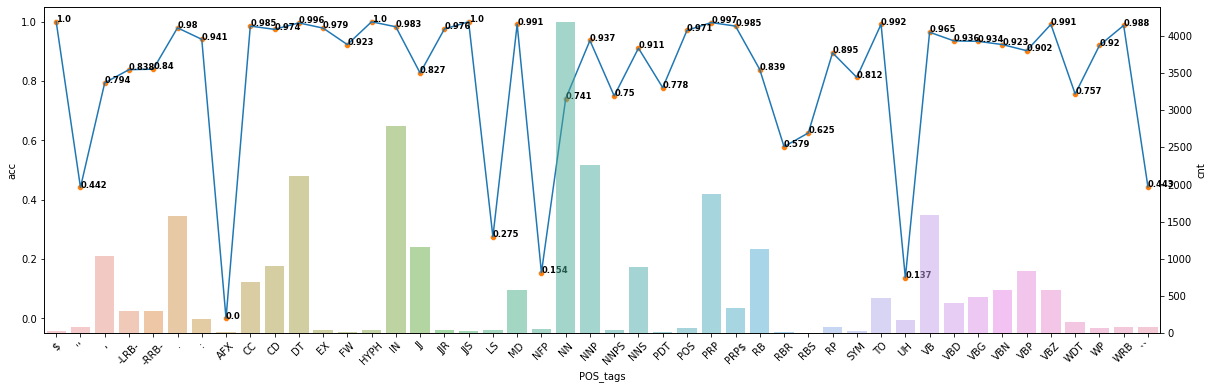

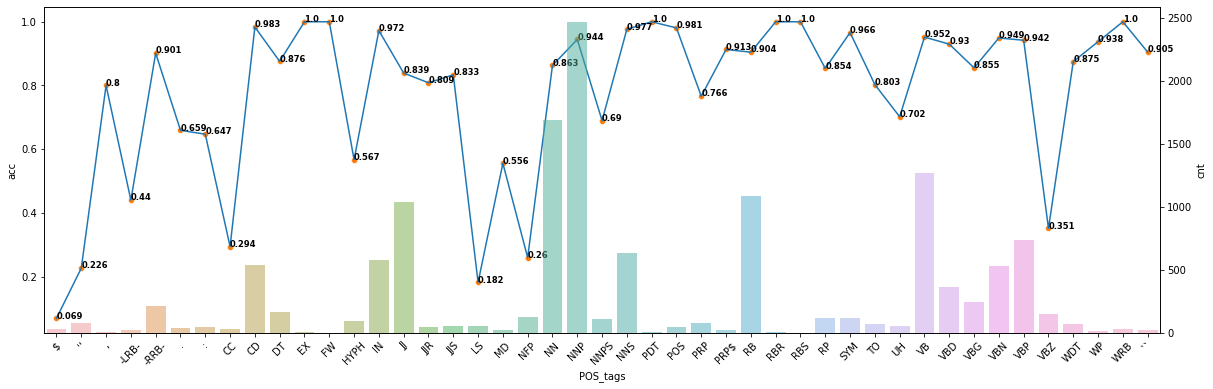

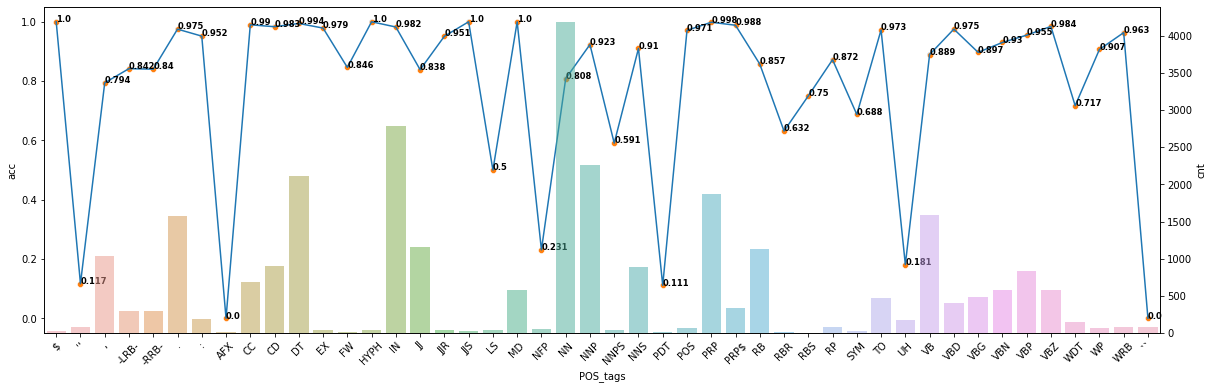

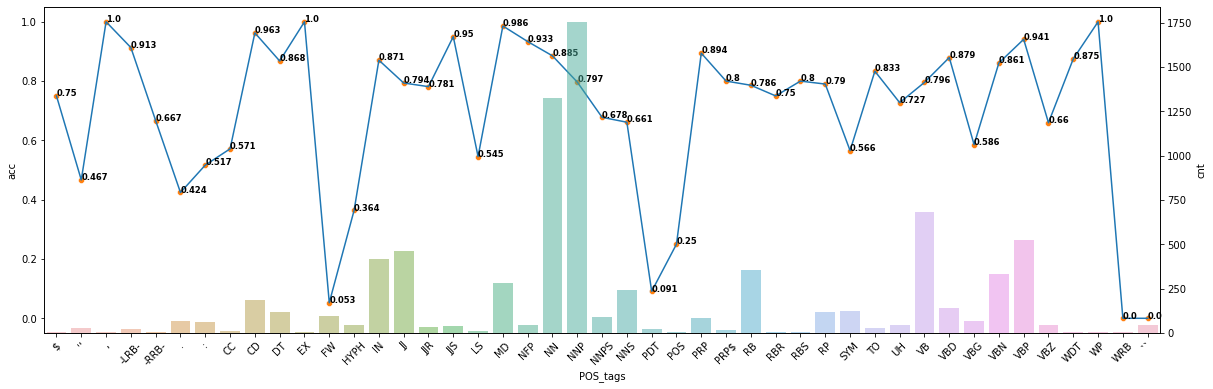

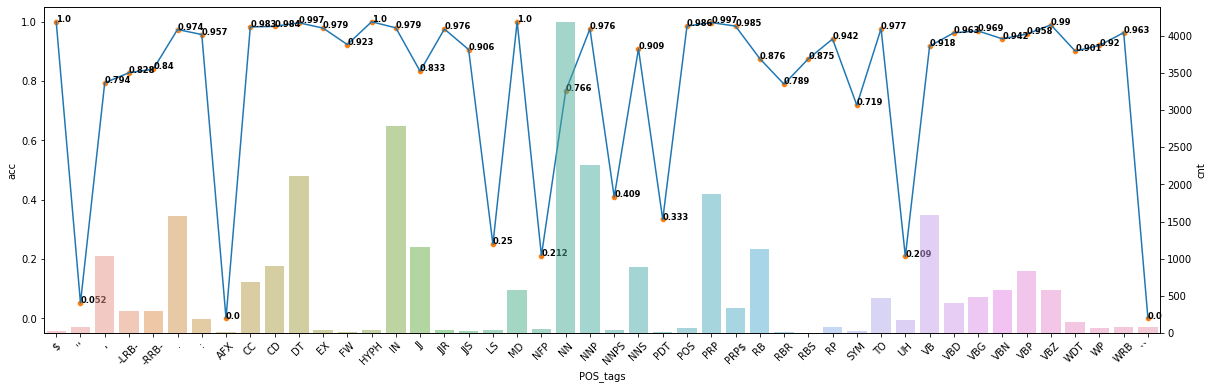

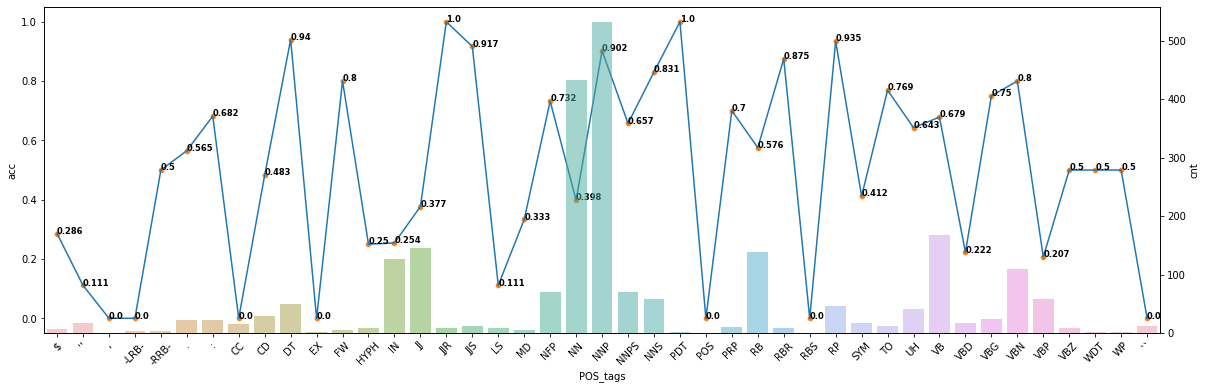

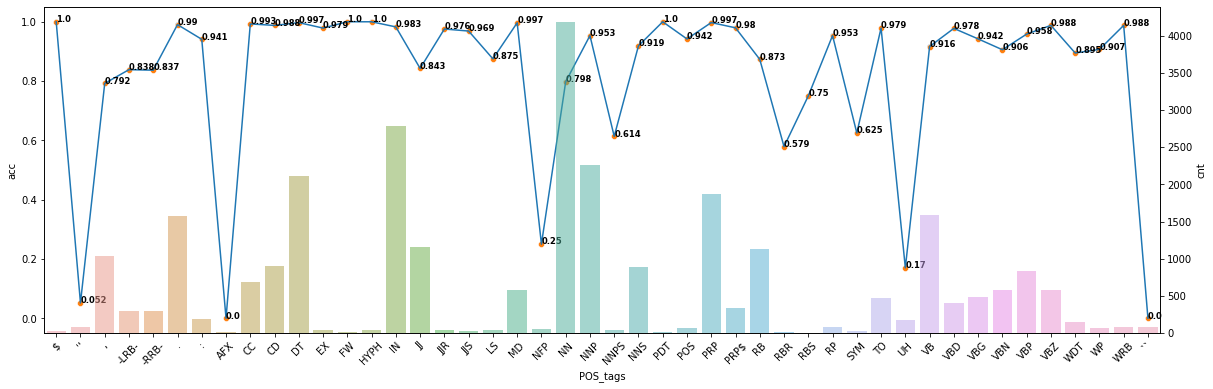

In [ ]:
token_prob_lst = []

while cnt_non_ignored_tokens >= token_topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)

  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}.txt")

  (top_words, top_tags, top_pseudo_tags, top_prob_pseudo_tags, top_prob, top_acc,
   remain_words, remain_tags, remain_pseudo_tags, remain_prob_pseudo_tags, remain_prob, remain_acc) = gen_pseudo_data_for_token(
       model, domain_dev_iter, topn=len(domain_dev_word_lst), save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)

  print(len(top_prob_pseudo_tags))
  assert len(top_words)==len(top_tags)==len(top_prob_pseudo_tags)

  cnt_all_words = sum([len(s) for s in top_words])
  cnt_all_tags = sum([len(s) for s in top_tags])
  cnt_all_probs = sum([len(s) for s in top_prob_pseudo_tags])
  # print("Total tokens", cnt_all_probs)
  assert cnt_all_words==cnt_all_tags==cnt_all_probs

  non_ignored_tokens = []
  for tokens_i in top_tags:
    for token_i in tokens_i:
      if token_i != '<pad>':
        non_ignored_tokens.append(token_i)
  cnt_non_ignored_tokens = len(non_ignored_tokens)
  print("Total non_ignored tokens", cnt_non_ignored_tokens)
  if cnt_non_ignored_tokens <= 100:
    print("The number of non-ignored tokens is too few. Stop training")
    break
    
  # Calculate threshold_prob
  all_pseudo_tags_prob_lst = []
  for top_tags_i, top_prob_pseudo_tags_i in zip(top_tags, top_prob_pseudo_tags):
    for tags_i, prob_pseudo_tags_i in zip(top_tags_i, top_prob_pseudo_tags_i):
      if tags_i != '<pad>':
        all_pseudo_tags_prob_lst.append(prob_pseudo_tags_i)
  all_pseudo_tags_prob_lst.sort(reverse=True)

  if token_topn >= len(all_pseudo_tags_prob_lst):
    threshold_prob = all_pseudo_tags_prob_lst[-1]
    token_prob_lst.append(all_pseudo_tags_prob_lst)
  else:
    threshold_prob = all_pseudo_tags_prob_lst[token_topn]
    token_prob_lst.append(
        all_pseudo_tags_prob_lst[: token_topn+1]
        )
  print("threshold_prob:", threshold_prob)

  # Filter tags by prob
  filter_top_tags = []
  remain_top_tags = []
  for t, p in zip(top_pseudo_tags, top_prob_pseudo_tags):
    t_lst = []
    remain_t_lst = []
    for t_i, p_i in zip(t, p):
      if t_i == '<pad>':
        t_lst.append('<pad>')
        remain_t_lst.append('<pad>')
      else:
        if p_i >= threshold_prob:
          t_lst.append(t_i)
          remain_t_lst.append('<pad>')
        else:
          t_lst.append('<pad>')
          remain_t_lst.append(t_i)

    filter_top_tags.append(t_lst)
    remain_top_tags.append(remain_t_lst)

  assert len(top_words)==len(filter_top_tags)

  domain_dev_word_lst = top_words
  domain_dev_tag_lst = remain_top_tags

  new_train_dataset = PosDataset(
      wsj_train_word_lst + top_words, 
      wsj_train_tag_lst + filter_top_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)

  print("Train from scratch...")
  model = Net(vocab_size=len(TAG2IDX))
  model.to(DEVICE)
  model = nn.DataParallel(model)

  optimizer = optim.Adam(model.parameters(), lr = 0.0001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)
  
  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{token_top_percent}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)



In [ ]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [ ]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [ ]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [ ]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)